In [165]:
!pip install yfinance

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# One risky asset + one risk-free asset

In [167]:
# Download stock data, which is automatically indexed by date
symbol = 'AAPL'
df = yf.download(symbol, start="2023-01-01", end="2023-12-31")
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,130.279999,130.899994,124.169998,125.070000,124.374802,112117500
2023-01-04,126.889999,128.660004,125.080002,126.360001,125.657639,89113600
2023-01-05,127.129997,127.769997,124.760002,125.019997,124.325081,80962700
2023-01-06,126.010002,130.289993,124.889999,129.619995,128.899521,87754700
2023-01-09,130.470001,133.410004,129.889999,130.149994,129.426575,70790800


In [168]:
# Calculate log return based on adjusted closing price
df['Log Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
df.head()

,Open,High,Low,Close,Adj Close,Volume,Log Return
Date,,,,,,,
2023-01-03,130.279999,130.899994,124.169998,125.070000,124.374802,112117500,NaN
2023-01-04,126.889999,128.660004,125.080002,126.360001,125.657639,89113600,0.010261
2023-01-05,127.129997,127.769997,124.760002,125.019997,124.325081,80962700,-0.010661
2023-01-06,126.010002,130.289993,124.889999,129.619995,128.899521,87754700,0.036133
2023-01-09,130.470001,133.410004,129.889999,130.149994,129.426575,70790800,0.004081


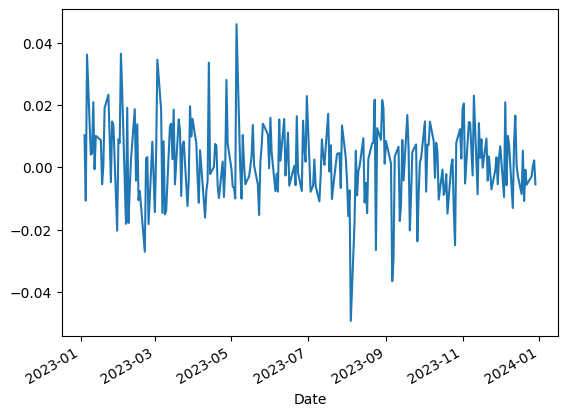

In [169]:
# Plot time series, where each observation is denoted as a dot and connected via line chart with each other
df['Log Return'].plot()
plt.show()

In [170]:
# Estimate asset return via sample mean
mu_bar = df['Log Return'].mean()
mu_bar

0.0017548288305700257

In [171]:
# Calculate annualized asset return via compounding, assuming 252 trading days
ann_mu_bar = np.exp(mu_bar * 252) - 1
ann_mu_bar

0.5561531794751624

In [172]:
# Estimate asset volatility via sample standard deviation
sigma_bar = df['Log Return'].std()
sigma_bar

0.012549821501632703

In [173]:
# We can also calculate the std manually
print(np.sqrt(df['Log Return'].var()))
print(np.sqrt(np.sum((df['Log Return'] - mu_bar)**2) / (len(df) - 1)))

0.012549821501632703
0.012524595704264506


In [174]:
# Calculate annualized volatility
ann_sigma_bar = sigma_bar * np.sqrt(252)
ann_sigma_bar

0.19922224014942788

In [175]:
# Introduce risk-free asset
rf = 0.01

In [176]:
# Calculate asset Sharpe ratio
sharpe_ratio = (ann_mu_bar - rf) / ann_sigma_bar
sharpe_ratio

2.741426755695131

In [177]:
# Form a portfolio of risky asset and risk-free asset with equal weightage
# Calculate the portfolio return
w1 = 0.5
w2 = 1 - w1
mu_bar_port = w1 * ann_mu_bar + w2 * rf
mu_bar_port

0.2830765897375812

In [178]:
# Calculate the portfolio volatility
sigma_bar_port = np.sqrt(w1**2 * ann_sigma_bar**2)
sigma_bar_port

0.09961112007471394

In [179]:
# Q: why is sigma_bar_port smaller than sigma_bar

In [180]:
# Calculate portfolio Sharpe ratio
sharpe_ratio_port = (mu_bar_port - rf) / sigma_bar_port
sharpe_ratio_port

2.741426755695131

In [181]:
# Q: why is the Sharpe ratio the same?

In [182]:
# Now we formulate a portfolio optimization problem and solve for optimal weights w1 and w2
# We aim to maximize the Sharpe ratio of the portfolio subject to long-only and budget constraint
from scipy.optimize import minimize

# Define the objective function (negative Sharpe ratio)
def neg_sharpe_ratio(weights, ann_mu_bar, ann_sigma_bar, rf):
    # Portfolio return
    port_return = weights[0] * ann_mu_bar + weights[1] * rf
    # Portfolio volatility
    port_volatility = weights[0] * ann_sigma_bar  # risk-free asset has zero volatility
    # Sharpe ratio (negative for minimization)
    return -(port_return - rf) / port_volatility

# Constraints for weights (budget constraint: weights sum to 1)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for weights (long-only constraint)
bounds = ((0, 1), (0, 1))  # no short selling, weights between 0 and 1

# Initial guess (start with equal allocation)
init_guess = [0.5, 0.5]

# Run the optimization
opt_results = minimize(neg_sharpe_ratio, init_guess, args=(ann_mu_bar, ann_sigma_bar, rf),
                       method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized weights
optimized_weights = opt_results.x

print(f"Optimized Weights: {optimized_weights}")
print(f"Maximized Sharpe Ratio: {-opt_results.fun}")


Optimized Weights: [0.5 0.5]
Maximized Sharpe Ratio: 2.741426755695131


In [183]:
# Q: why the optimal Sharpe ratio portfolio is also the same?

In [184]:
# Let us look at the maximum return portfolio
# We aim to maximize the return of the portfolio subject to long-only and budget constraint

# Define the objective function for return (which we want to maximize)
def portfolio_return(weights, ann_mu_bar, rf):
    # Portfolio return is the weighted average of the individual asset returns
    return weights[0] * ann_mu_bar + weights[1] * rf

# Since scipy's minimize function only minimizes, we can multiply the objective function by -1 to maximize
opt_results = minimize(lambda weights: -portfolio_return(weights, ann_mu_bar, rf),
                       init_guess,
                       method='SLSQP',
                       bounds=bounds,
                       constraints=constraints)

# Optimized weights for maximum return
optimized_weights_max_return = opt_results.x

print(f"Optimized Weights for Maximum Return: {optimized_weights_max_return}")
print(f"Maximum Expected Portfolio Return: {-opt_results.fun}")


Optimized Weights for Maximum Return: [1.00000000e+00 3.88578059e-16]
Maximum Expected Portfolio Return: 0.5561531794751622


In [185]:
# Q: why does the risky asset gets 100%?

In [186]:
# Let us look at the minimum variance portfolio
# We aim to minimize the portfolio volatility subject to long-only and budget constraint

# Define the objective function for volatility (which we want to minimize)
def portfolio_volatility(weights, ann_sigma_bar):
    # Portfolio volatility is the weighted average of the individual asset volatilities
    return weights[0] * ann_sigma_bar

opt_results = minimize(lambda weights: portfolio_volatility(weights, ann_sigma_bar),
                       init_guess,
                       method='SLSQP',
                       bounds=bounds,
                       constraints=constraints)

# Optimized weights for minimum volatility
optimized_weights_min_vol = opt_results.x

print(f"Optimized Weights for Minimum Volatility: {optimized_weights_min_vol}")
print(f"Minimum Expected Portfolio Volatility: {opt_results.fun}")

Optimized Weights for Minimum Volatility: [0. 1.]
Minimum Expected Portfolio Volatility: 0.0


In [187]:
# Q: why does the risky asset gets 0%?

# Two risky assets

In [188]:
# Download stock data, which is automatically indexed by date
symbol = ['GOOG','WMT']
df = yf.download(symbol, start="2023-01-01", end="2023-12-31")
df.head()

[*********************100%%**********************]  2 of 2 completed


Price       Adj Close                  Close                   High  \
Ticker           GOOG         WMT       GOOG         WMT       GOOG   
Date                                                                  
2023-01-03  89.699997  141.442596  89.699997  143.600006  91.550003   
2023-01-04  88.709999  141.600204  88.709999  143.759995  91.239998   
2023-01-05  86.769997  141.117569  86.769997  143.270004  88.209999   
2023-01-06  88.160004  144.574829  88.160004  146.779999  88.470001   
2023-01-09  88.800003  142.772324  88.800003  144.949997  90.830002   

Price                         Low                   Open              \
Ticker             WMT       GOOG         WMT       GOOG         WMT   
Date                                                                   
2023-01-03  143.710007  89.019997  142.089996  89.830002  142.550003   
2023-01-04  144.050003  87.800003  142.070007  91.010002  143.419998   
2023-01-05  144.130005  86.559998  142.649994  88.070000  143.460007   
2023-01-06  147.550003  85.570000  144.240005  87.360001  144.600006   
2023-01-09  147.860001  88.580002  144.800003  89.195000  146.320007   

Price         Volume           
Ticker          GOOG      WMT  
Date                           
2023-01-03  20738500  5749900  
2023-01-04  27046500  4446100  
2023-01-05  23136100  4424800  
2023-01-06  26612600  7077300  
2023-01-09  22996700  5918900

In [189]:
# Focus on adj close
df = df['Adj Close']
df.head()

Ticker,GOOG,WMT
Date,,
2023-01-03,89.699997,141.442596
2023-01-04,88.709999,141.600204
2023-01-05,86.769997,141.117569
2023-01-06,88.160004,144.574829
2023-01-09,88.800003,142.772324


In [190]:
# Calculate the log return based on adj closing price for each asset
df = np.log(df / df.shift(1))
df.head()

Ticker,GOOG,WMT
Date,,
2023-01-03,NaN,NaN
2023-01-04,-0.011098,0.001114
2023-01-05,-0.022112,-0.003414
2023-01-06,0.015892,0.024204
2023-01-09,0.007233,-0.012546


<Axes: xlabel='Date'>

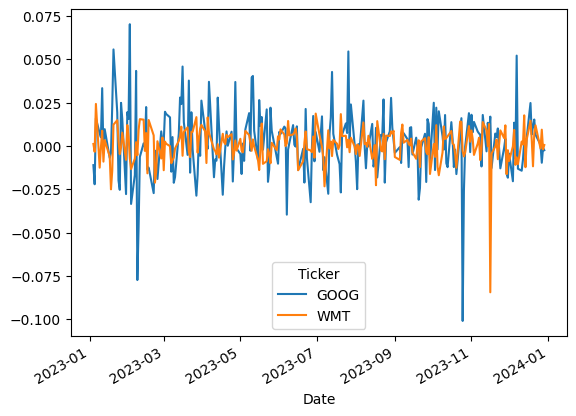

In [191]:
# Plot the log returns
df.plot()

In [192]:
# Calculate annualized return and volatility for each asset
ann_mu = df.mean() * 252
ann_sigma = df.std() * np.sqrt(252)
print(f"Annualized Return: {ann_mu}")
print(f"Annualized Volatility: {ann_sigma}")

Annualized Return: Ticker
GOOG    0.457236
WMT     0.109790
dtype: float64
Annualized Volatility: Ticker
GOOG    0.306677
WMT     0.158127
dtype: float64


In [193]:
# Calculate annualized sample covariance matrix
cov_matrix = df.cov() * 252
print(f"Annualized Sample Covariance Matrix: \n{cov_matrix}")

Annualized Sample Covariance Matrix: 
Ticker      GOOG       WMT
Ticker                    
GOOG    0.094051  0.005888
WMT     0.005888  0.025004


In [194]:
# Assume a portfolio of equal weightage
# Calculate the portfolio return and volatility
portfolio_return = ann_mu[0] * 0.5 + ann_mu[1] * 0.5
portfolio_volatility = np.sqrt(
    0.5**2 * cov_matrix.iloc[0, 0] +
    0.5**2 * cov_matrix.iloc[1, 1] +
    2 * 0.5 * 0.5 * cov_matrix.iloc[0, 1]
)
print(f"Portfolio Return: {portfolio_return}")
print(f"Portfolio Volatility: {portfolio_volatility}")

Portfolio Return: 0.2835131149264394
Portfolio Volatility: 0.18085285697603787


In [195]:
# Maximize Sharpe ratio
# We aim to maximize the Sharpe ratio subject to long-only and budget constraint

# Function to calculate the portfolio return
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

# Function to calculate the portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate the negative Sharpe ratio (since we're minimizing)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_ret = portfolio_return(weights, mean_returns)
    p_vol = portfolio_volatility(weights, cov_matrix)
    return -(p_ret - risk_free_rate) / p_vol

# Function to be called by the optimizer
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Budget constraint
    bounds = tuple((0, 1) for asset in range(num_assets))  # Long-only constraint

    # Initial guess (equal distribution)
    init_guess = num_assets * [1. / num_assets,]

    # Optimization
    opt_results = minimize(neg_sharpe_ratio, init_guess, args=args,
                           method='SLSQP', bounds=bounds, constraints=constraints)

    return opt_results

# Example usage:
opt_results = max_sharpe_ratio(mean_returns=ann_mu, cov_matrix=cov_matrix, risk_free_rate=rf)

print("Optimized Weights:", opt_results.x)
print("Maximized Sharpe Ratio:", -opt_results.fun)


Optimized Weights: [0.6109601 0.3890399]
Maximized Sharpe Ratio: 1.5283754208860696


In [196]:
# Maximum return portfolio

# Function to calculate the negative portfolio return (since we're minimizing)
def neg_portfolio_return(weights, mean_returns):
    return -portfolio_return(weights, mean_returns)

# Function to be called by the optimizer to maximize the portfolio return
def max_return_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Budget constraint
    bounds = tuple((0, 1) for asset in range(num_assets))  # Long-only constraint

    # Initial guess (equal distribution)
    init_guess = num_assets * [1. / num_assets,]

    # Optimization to maximize the return (by minimizing the negative return)
    opt_results = minimize(neg_portfolio_return, init_guess, args=args,
                           method='SLSQP', bounds=bounds, constraints=constraints)

    return opt_results

# Example usage:
mean_returns = ann_mu  # assuming ann_mu is a variable containing the annualized mean returns
cov_matrix = cov_matrix  # assuming cov_matrix is a variable containing the annualized covariance matrix

opt_results = max_return_portfolio(mean_returns=mean_returns, cov_matrix=cov_matrix)

print("Optimized Weights:", opt_results.x)
print("Maximum Expected Portfolio Return:", -opt_results.fun)


Optimized Weights: [1.00000000e+00 2.22044605e-16]
Maximum Expected Portfolio Return: 0.45723580963795146


In [197]:
# Minimum variance portfolio

# Function to be called by the optimizer to minimize portfolio variance
def min_variance_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (cov_matrix,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Budget constraint
    bounds = tuple((0, 1) for asset in range(num_assets))  # Long-only constraint

    # Initial guess (equal distribution)
    init_guess = num_assets * [1. / num_assets,]

    # Objective function to minimize (portfolio volatility)
    def portfolio_volatility(weights, cov_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Optimization to minimize the volatility
    opt_results = minimize(portfolio_volatility, init_guess, args=args,
                           method='SLSQP', bounds=bounds, constraints=constraints)

    return opt_results

# Example usage:
mean_returns = ann_mu  # assuming ann_mu is a variable containing the annualized mean returns
cov_matrix = cov_matrix  # assuming cov_matrix is a variable containing the annualized covariance matrix

opt_results = min_variance_portfolio(mean_returns=mean_returns, cov_matrix=cov_matrix)

print("Optimized Weights:", opt_results.x)
print("Minimum Portfolio Volatility:", opt_results.fun)


Optimized Weights: [0.17805287 0.82194713]
Minimum Portfolio Volatility: 0.14696221420438757


In [198]:
# MVO for a given lambda

# Function to be called by the optimizer to minimize the mvo objective
def mvo_with_risk_aversion(mean_returns, cov_matrix, risk_aversion):
    num_assets = len(mean_returns)
    args = (cov_matrix, mean_returns, risk_aversion)

    # Define the objective function
    def objective_function(weights, cov_matrix, mean_returns, risk_aversion):
        # Calculate the portfolio return and volatility
        p_ret = portfolio_return(weights, mean_returns)
        p_vol = portfolio_volatility(weights, cov_matrix)
        return risk_aversion * p_vol - p_ret

    # Constraints: Weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds for weights: No short selling
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Initial guess: Equal weights
    init_guess = num_assets * [1. / num_assets, ]

    # Optimization
    opt_results = minimize(objective_function, init_guess, args=args,
                           method='SLSQP', bounds=bounds, constraints=constraints)

    return opt_results

# Example usage:
lambda_value = 2  # This is the risk aversion parameter
opt_results = mvo_with_risk_aversion(mean_returns=ann_mu, cov_matrix=cov_matrix, risk_aversion=lambda_value)

print("Optimized Weights:", opt_results.x)
print("Optimized Objective Value:", opt_results.fun)


Optimized Weights: [0.45897327 0.54102673]
Optimized Objective Value: 0.07747229502776265


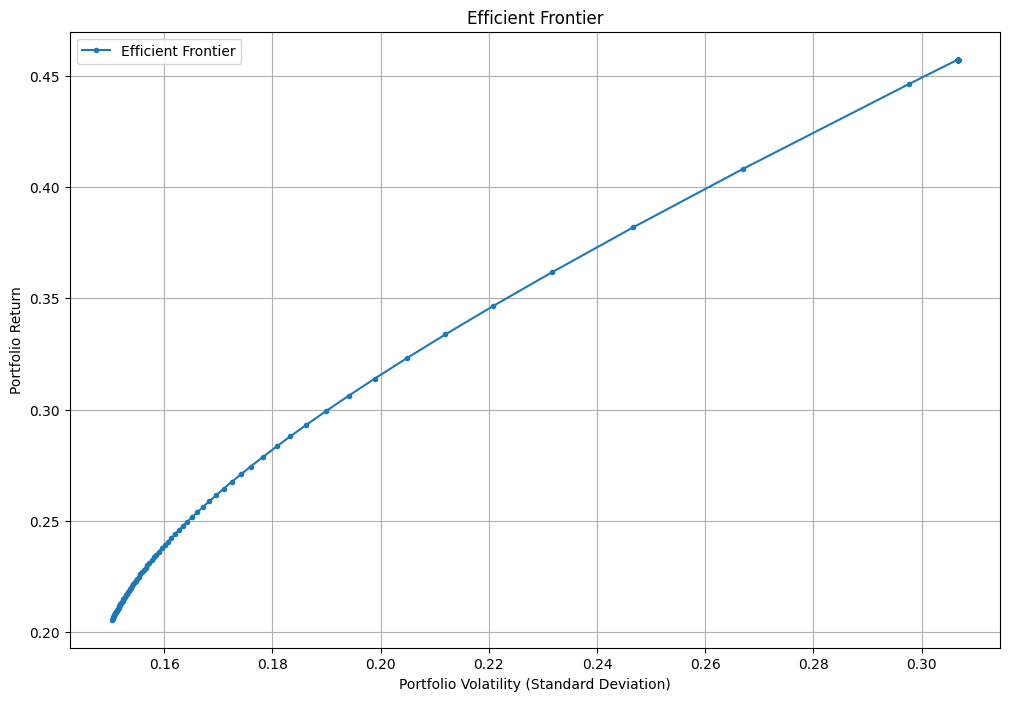

In [199]:
# Draw efficient frontier

# Define a range of lambda values
lambda_values = np.linspace(0.01, 5, 100)

# Prepare lists to hold the results
portfolio_returns = []
portfolio_volatilities = []

# Calculate optimal portfolio for each lambda value
for lambda_value in lambda_values:
    opt_results = mvo_with_risk_aversion(mean_returns, cov_matrix, lambda_value)
    weights = opt_results.x
    p_ret = portfolio_return(weights, mean_returns)
    p_vol = portfolio_volatility(weights, cov_matrix)
    portfolio_returns.append(p_ret)
    portfolio_volatilities.append(p_vol)

# Convert lists to numpy arrays for plotting
portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)

# Plot the efficient frontier
plt.figure(figsize=(12, 8))
plt.plot(portfolio_volatilities, portfolio_returns, 'o-', markersize=3, label='Efficient Frontier')
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Volatility (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()


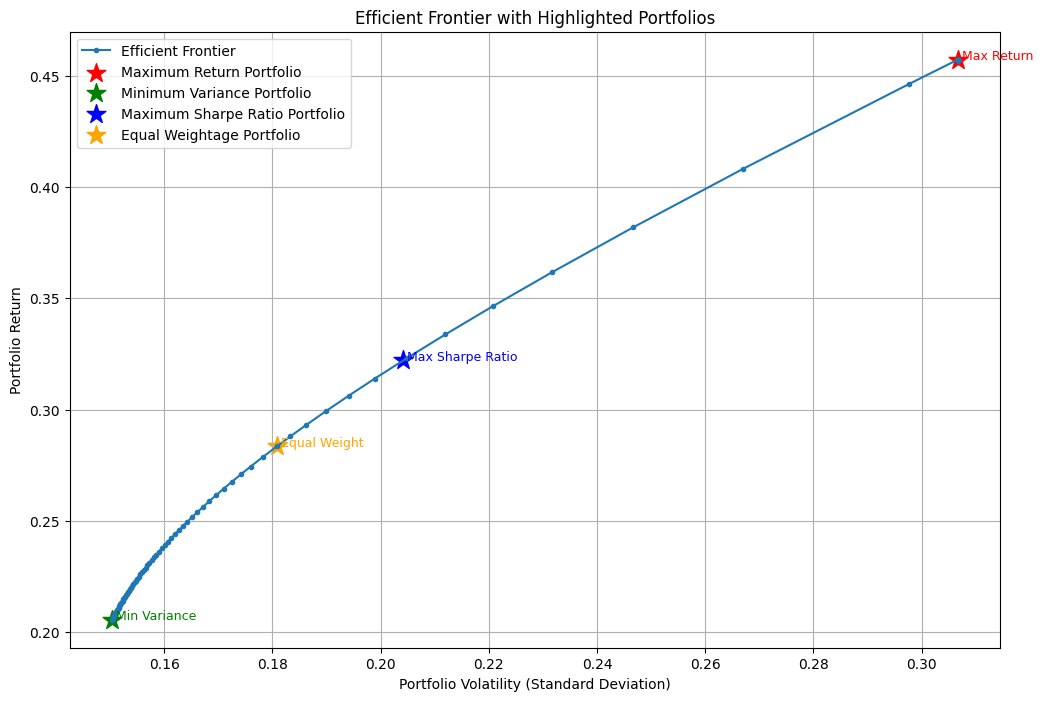

In [200]:
# Identify the maximum return portfolio
max_return_idx = np.argmax(portfolio_returns)
max_return_volatility = portfolio_volatilities[max_return_idx]
max_return = portfolio_returns[max_return_idx]

# Identify the minimum variance portfolio
min_vol_idx = np.argmin(portfolio_volatilities)
min_volatility = portfolio_volatilities[min_vol_idx]
min_return = portfolio_returns[min_vol_idx]

# Find the maximum Sharpe ratio portfolio
sharpe_opt_results = max_sharpe_ratio(mean_returns=ann_mu, cov_matrix=cov_matrix, risk_free_rate=rf)
max_sharpe_weights = sharpe_opt_results.x
max_sharpe_return = portfolio_return(max_sharpe_weights, ann_mu)
max_sharpe_volatility = portfolio_volatility(max_sharpe_weights, cov_matrix)

# Find the equal weightage portfolio
equal_weights = np.array([1. / len(ann_mu)] * len(ann_mu))
equal_weight_return = portfolio_return(equal_weights, ann_mu)
equal_weight_volatility = portfolio_volatility(equal_weights, cov_matrix)

# Plot the efficient frontier
plt.figure(figsize=(12, 8))
plt.plot(portfolio_volatilities, portfolio_returns, 'o-', markersize=3, label='Efficient Frontier')
plt.scatter(max_return_volatility, max_return, marker='*', color='red', s=200, label='Maximum Return Portfolio')
plt.scatter(min_volatility, min_return, marker='*', color='green', s=200, label='Minimum Variance Portfolio')
plt.scatter(max_sharpe_volatility, max_sharpe_return, marker='*', color='blue', s=200, label='Maximum Sharpe Ratio Portfolio')
plt.scatter(equal_weight_volatility, equal_weight_return, marker='*', color='orange', s=200, label='Equal Weightage Portfolio')

# Add label text for the portfolios
plt.text(max_return_volatility, max_return, ' Max Return', fontsize=9, color='red')
plt.text(min_volatility, min_return, ' Min Variance', fontsize=9, color='green')
plt.text(max_sharpe_volatility, max_sharpe_return, ' Max Sharpe Ratio', fontsize=9, color='blue')
plt.text(equal_weight_volatility, equal_weight_return, ' Equal Weight', fontsize=9, color='orange')

plt.title('Efficient Frontier with Highlighted Portfolios')
plt.xlabel('Portfolio Volatility (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()

# Three risky assets

In [211]:
# Download stock data, which is automatically indexed by date
symbol = ['GOOG','MSFT','WMT']
df = yf.download(symbol, start="2023-01-01", end="2023-12-31")['Adj Close']
df = np.log(df / df.shift(1))
mean_returns = df.mean() * 252
cov_matrix = df.cov() * 252
print('Annualized return: ', mean_returns)
print('Annualized variance: ', cov_matrix)

[*********************100%%**********************]  3 of 3 completed

Annualized return:  Ticker
GOOG    0.457236
MSFT    0.465174
WMT     0.109790
dtype: float64
Annualized variance:  Ticker      GOOG      MSFT       WMT
Ticker                              
GOOG    0.094051  0.039409  0.005888
MSFT    0.039409  0.062544  0.004831
WMT     0.005888  0.004831  0.025004


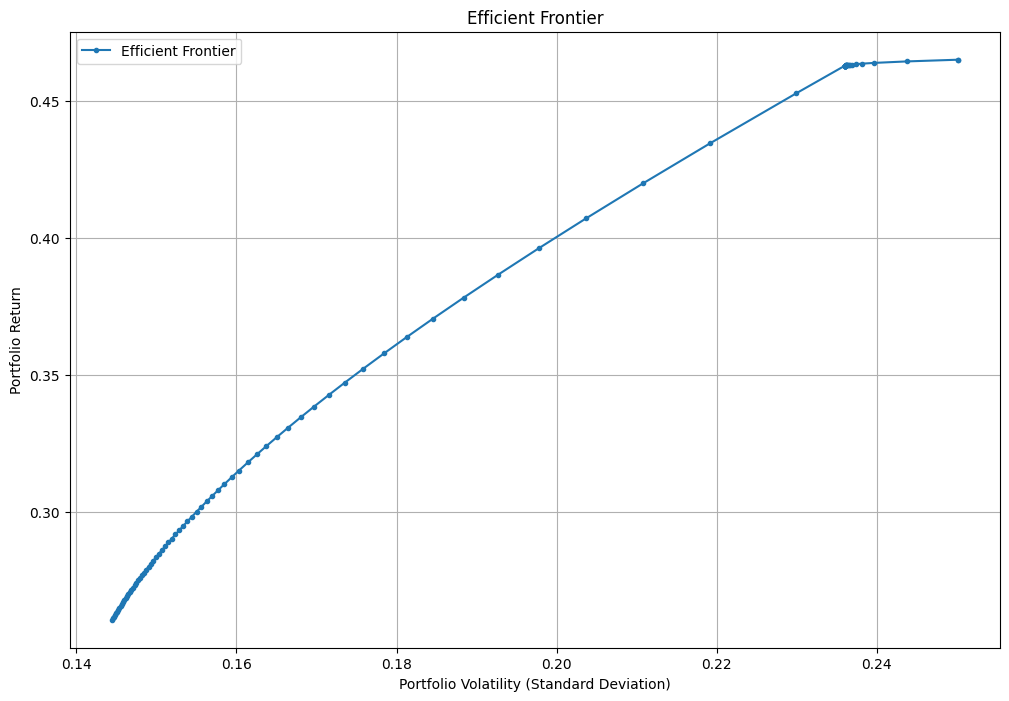

In [212]:
# Draw efficient frontier

# Define a range of lambda values
lambda_values = np.linspace(0.01, 5, 100)

# Prepare lists to hold the results
portfolio_returns = []
portfolio_volatilities = []

# Calculate optimal portfolio for each lambda value
for lambda_value in lambda_values:
    opt_results = mvo_with_risk_aversion(mean_returns, cov_matrix, lambda_value)
    weights = opt_results.x
    p_ret = portfolio_return(weights, mean_returns)
    p_vol = portfolio_volatility(weights, cov_matrix)
    portfolio_returns.append(p_ret)
    portfolio_volatilities.append(p_vol)

# Convert lists to numpy arrays for plotting
portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)

# Plot the efficient frontier
plt.figure(figsize=(12, 8))
plt.plot(portfolio_volatilities, portfolio_returns, 'o-', markersize=3, label='Efficient Frontier')
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Volatility (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()


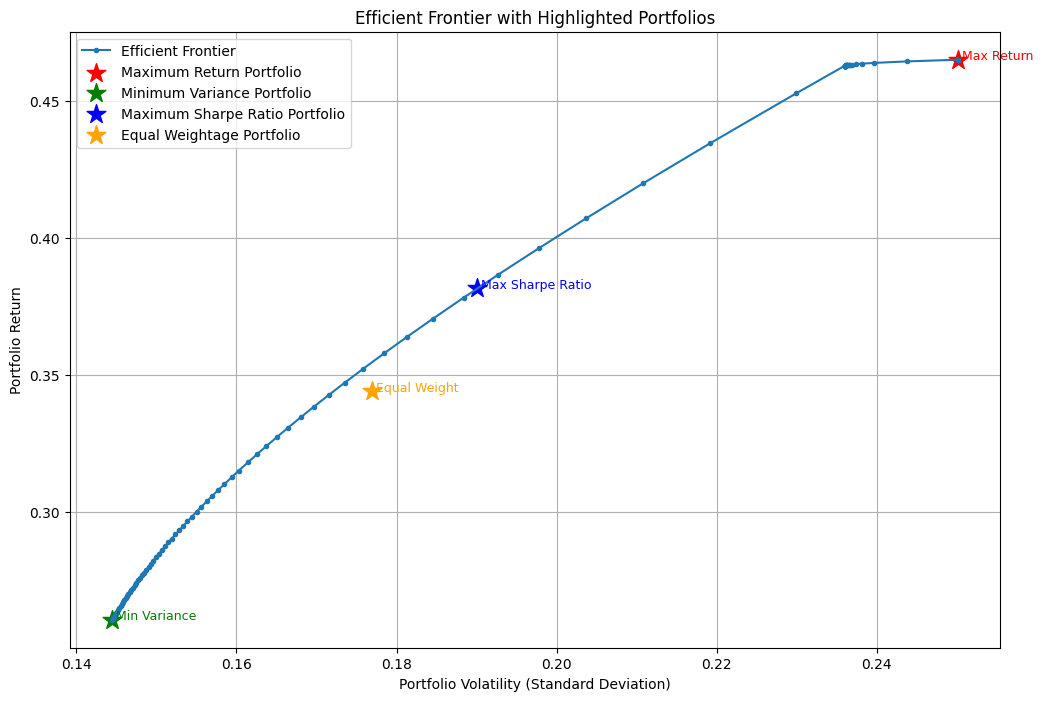

In [213]:
# Identify the maximum return portfolio
max_return_idx = np.argmax(portfolio_returns)
max_return_volatility = portfolio_volatilities[max_return_idx]
max_return = portfolio_returns[max_return_idx]

# Identify the minimum variance portfolio
min_vol_idx = np.argmin(portfolio_volatilities)
min_volatility = portfolio_volatilities[min_vol_idx]
min_return = portfolio_returns[min_vol_idx]

# Find the maximum Sharpe ratio portfolio
sharpe_opt_results = max_sharpe_ratio(mean_returns=ann_mu, cov_matrix=cov_matrix, risk_free_rate=rf)
max_sharpe_weights = sharpe_opt_results.x
max_sharpe_return = portfolio_return(max_sharpe_weights, ann_mu)
max_sharpe_volatility = portfolio_volatility(max_sharpe_weights, cov_matrix)

# Find the equal weightage portfolio
equal_weights = np.array([1. / len(ann_mu)] * len(ann_mu))
equal_weight_return = portfolio_return(equal_weights, ann_mu)
equal_weight_volatility = portfolio_volatility(equal_weights, cov_matrix)

# Plot the efficient frontier
plt.figure(figsize=(12, 8))
plt.plot(portfolio_volatilities, portfolio_returns, 'o-', markersize=3, label='Efficient Frontier')
plt.scatter(max_return_volatility, max_return, marker='*', color='red', s=200, label='Maximum Return Portfolio')
plt.scatter(min_volatility, min_return, marker='*', color='green', s=200, label='Minimum Variance Portfolio')
plt.scatter(max_sharpe_volatility, max_sharpe_return, marker='*', color='blue', s=200, label='Maximum Sharpe Ratio Portfolio')
plt.scatter(equal_weight_volatility, equal_weight_return, marker='*', color='orange', s=200, label='Equal Weightage Portfolio')

# Add label text for the portfolios
plt.text(max_return_volatility, max_return, ' Max Return', fontsize=9, color='red')
plt.text(min_volatility, min_return, ' Min Variance', fontsize=9, color='green')
plt.text(max_sharpe_volatility, max_sharpe_return, ' Max Sharpe Ratio', fontsize=9, color='blue')
plt.text(equal_weight_volatility, equal_weight_return, ' Equal Weight', fontsize=9, color='orange')

plt.title('Efficient Frontier with Highlighted Portfolios')
plt.xlabel('Portfolio Volatility (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()

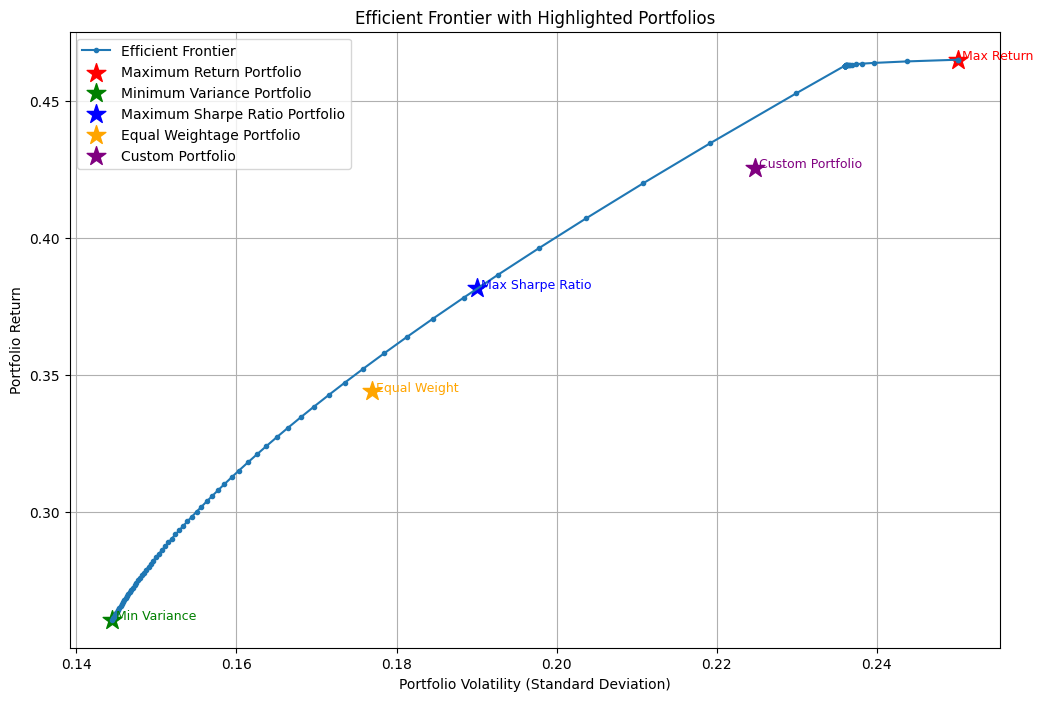

In [214]:
# Add custom portfolio
custom_weights = np.array([0.5, 0.4, 0.1])
custom_portfolio_return = portfolio_return(custom_weights, ann_mu)
custom_portfolio_volatility = portfolio_volatility(custom_weights, cov_matrix)

# Plot the efficient frontier with all the portfolios
plt.figure(figsize=(12, 8))
plt.plot(portfolio_volatilities, portfolio_returns, 'o-', markersize=3, label='Efficient Frontier')
plt.scatter(max_return_volatility, max_return, marker='*', color='red', s=200, label='Maximum Return Portfolio')
plt.scatter(min_volatility, min_return, marker='*', color='green', s=200, label='Minimum Variance Portfolio')
plt.scatter(max_sharpe_volatility, max_sharpe_return, marker='*', color='blue', s=200, label='Maximum Sharpe Ratio Portfolio')
plt.scatter(equal_weight_volatility, equal_weight_return, marker='*', color='orange', s=200, label='Equal Weightage Portfolio')
plt.scatter(custom_portfolio_volatility, custom_portfolio_return, marker='*', color='purple', s=200, label='Custom Portfolio')

# Add label text for all the portfolios
plt.text(max_return_volatility, max_return, ' Max Return', fontsize=9, color='red')
plt.text(min_volatility, min_return, ' Min Variance', fontsize=9, color='green')
plt.text(max_sharpe_volatility, max_sharpe_return, ' Max Sharpe Ratio', fontsize=9, color='blue')
plt.text(equal_weight_volatility, equal_weight_return, ' Equal Weight', fontsize=9, color='orange')
plt.text(custom_portfolio_volatility, custom_portfolio_return, ' Custom Portfolio', fontsize=9, color='purple')

plt.title('Efficient Frontier with Highlighted Portfolios')
plt.xlabel('Portfolio Volatility (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()


In [202]:
equal_weights

array([0.5, 0.5])